In [1]:
%load_ext tensorboard

In [2]:
from pandas import read_parquet
from data import file

data_train = read_parquet(file.news_articles_cleaned_train)
data_test = read_parquet(file.news_articles_cleaned_test)

In [3]:
data_train

,text_original,label,text_tokenized,text_tokenized_keywords,text_keywords,text_tokenized_lemmas,text_lemmas,text_tokenized_stemmed,text_stem
0,21-Jähriger fällt wohl bis Saisonende aus. Wie...,Sport,"[21-jähriger, fällt, wohl, bis, saisonende, au...","[21-jähriger, fällt, wohl, saisonende, ., wien...",21-jähriger fällt wohl saisonende . wien – rap...,"[21-jähriger, fällen, wohl, saisonende, wien, ...",21-jähriger fällen wohl saisonende wien rapid ...,"[21-jahrig, fallt, wohl, saison, wien, rapid, ...",21-jahrig fallt wohl saison wien rapid wohl sa...
1,"Erfundene Bilder zu Filmen, die als verloren g...",Kultur,"[erfundene, bilder, zu, filmen, ,, die, als, v...","[erfundene, bilder, filmen, ,, verloren, gelte...","erfundene bilder filmen , verloren gelten : ``...","[erfunden, bilder, filmen, verlieren, gelten, ...",erfunden bilder filmen verlieren gelten `` the...,"[erfund, bild, film, verlor, gelt, ``, the, fo...",erfund bild film verlor gelt `` the forbidd ro...
2,Der frischgekürte CEO Sundar Pichai setzt auf ...,Web,"[der, frischgekürte, ceo, sundar, pichai, setz...","[frischgekürte, ceo, sundar, pichai, setzt, um...",frischgekürte ceo sundar pichai setzt umgängli...,"[frischgekürte, ceo, sundar, pichai, setzen, u...",frischgekürte ceo sundar pichai setzen umgängl...,"[frischgekurt, ceo, sundar, pichai, setzt, umg...",frischgekurt ceo sundar pichai setzt umgang fu...
3,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",Wirtschaft,"[putin, :, ``, einigung, ,, dass, wir, menge, ...","[putin, :, ``, einigung, ,, menge, niveau, jän...","putin : `` einigung , menge niveau jänner halt...","[putin, ``, einigung, menge, niveau, jänner, h...",putin `` einigung menge niveau jänner halten m...,"[putin, ``, einig, meng, niveau, jann, halt, '...",putin `` einig meng niveau jann halt '' moskau...
4,Estland sieht den künftigen österreichischen P...,Inland,"[estland, sieht, den, künftigen, österreichisc...","[estland, sieht, künftigen, österreichischen, ...",estland sieht künftigen österreichischen präsi...,"[estland, sehen, künftig, österreichisch, präs...",estland sehen künftig österreichisch präsident...,"[estland, sieht, kunftig, osterreich, prasiden...",estland sieht kunftig osterreich prasident est...
...,...,...,...,...,...,...,...,...,...
9240,Bernd Saurer war Bridge-Juniorenweltmeister un...,Inland,"[bernd, saurer, war, bridge-juniorenweltmeiste...","[bernd, saurer, bridge-juniorenweltmeister, ,,...","bernd saurer bridge-juniorenweltmeister , krau...","[bernd, sauer, bridge-juniorenweltmeister, kra...",bernd sauer bridge-juniorenweltmeister krauss ...,"[bernd, saur, bridge-juniorenweltmeist, krauss...",bernd saur bridge-juniorenweltmeist krauss sch...
9241,Sandhere soll in vergangener Woche bei Luftang...,International,"[sandhere, soll, in, vergangener, woche, bei, ...","[sandhere, vergangener, woche, luftangriff, ge...",sandhere vergangener woche luftangriff getötet...,"[sandhere, vergangen, woche, luftangriff, töte...",sandhere vergangen woche luftangriff töten wer...,"[sandh, vergang, woch, luftangriff, getotet, w...",sandh vergang woch luftangriff getotet word wa...
9242,Derzeit Konzeptgruppe in Berlin – Kein Komment...,Wirtschaft,"[derzeit, konzeptgruppe, in, berlin, –, kein, ...","[derzeit, konzeptgruppe, berlin, –, kommentar,...",derzeit konzeptgruppe berlin – kommentar apple...,"[derzeit, konzeptgruppe, berlin, kommentar, ap...",derzeit konzeptgruppe berlin kommentar apple m...,"[derzeit, konzeptgrupp, berlin, kommentar, app...",derzeit konzeptgrupp berlin kommentar appl mag...
9243,Landeshauptmann will den vierten Regierungssit...,Inland,"[landeshauptmann, will, den, vierten, regierun...","[landeshauptmann, vierten, regierungssitz, erh...",landeshauptmann vierten regierungssitz erhalte...,"[landeshauptmann, viert, regierungssitz, erhal...",landeshauptmann viert regierungssitz erhalten ...,"[landeshauptmann, viert, regierungssitz, erhal...",landeshauptmann viert regierungssitz erhalt fp...


In [4]:
from keras.layers import TextVectorization
import fasttext.util
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, InputLayer
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Sequential
import numpy as np
import os
import datetime
from tensorflow import keras
from keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam


def get_embedder_fasttext(embedding_dim, model_name="cc.de.300.bin"):
    split = model_name.split(".")
    model_lang = split[1]
    model_dim = int(split[2])

    try:
        ft = fasttext.load_model(model_name)
    except ValueError:
        fasttext.util.download_model(model_lang, if_exists='ignore')
        ft = fasttext.load_model(model_name)

    if embedding_dim < model_dim:
        fasttext.util.reduce_model(ft, embedding_dim)

    def fasttext_embedder(word):
        return ft.get_word_vector(word)

    return fasttext_embedder


def calculate_embedding_matrix(vocabulary, embedding_dim=300, verbose=False):
    """Creates the embedding matrix
    """
    voc_size = len(vocabulary)
    words_not_found = set()
    embedding_matrix = np.zeros((voc_size, embedding_dim))

    embedder = get_embedder_fasttext(embedding_dim)
    
    
    for idx, word in enumerate(vocabulary):
        embedding_vector = embedder(word)
        if (embedding_vector is not None) and len(embedding_vector) > 0 and not np.all(embedding_vector == 0):
            # words not found in embedding index will be all-zeros.
            embedding_matrix[idx] = embedding_vector
        else:
            words_not_found.add(word)

    if verbose:
        print("Embedding type: fasttext")
        print("Number of null word embeddings:", np.sum(np.sum(embedding_matrix, axis=1) == 0))
        nr_words_not_found = len(words_not_found)
        print("Words not found in total:", len(words_not_found))
        if nr_words_not_found > 0:
            import random

            nr_sample = min(20, len(words_not_found))
            print("Words without embedding (", nr_sample, "/", nr_words_not_found, "): ",
                  random.sample(words_not_found, nr_sample), sep='')

    return embedding_matrix


def extract_vocabulary_and_set(data, verbose=False):
    sequence_length_percentil_cutoff = 0.98
    sequence_length_max = 768

    vocabulary = set()
    _ = data.apply(lambda x: vocabulary.update(x))

    lengths = data.apply(len)
    max_sequence_length = int(lengths.quantile(1.0))
    percentil_sequence_length = int(lengths.quantile(0.98))
    median_sequence_length = int(lengths.quantile(0.5))
    embedding_sequence_length = min(sequence_length_max, percentil_sequence_length)

    if verbose:
        print(f"Median sequence length:       : {median_sequence_length}")
        print(f"Percentil                     : {sequence_length_percentil_cutoff})")
        print(f"Cutoff sequence length        : {percentil_sequence_length}")
        print(f"Max sequence length           : {max_sequence_length}")
        print(f"Used embedding sequence length: {embedding_sequence_length}")
        print(f"Vocabulary length             : {len(vocabulary)}")

    return (vocabulary, embedding_sequence_length)


def compile_model(model, loss_function="categorical_crossentropy", learning_rate=0.01, model_metric = ["accuracy"]):
    adam = Adam(learning_rate=learning_rate)
    model.compile(loss=loss_function, optimizer=adam, metrics=model_metric)
    
    
def build_model_cnn_simple(X_train, y_train, conv_num_filters=128, conv_kernel_size=7):

    vocabulary, embedding_length = extract_vocabulary_and_set(X_train, verbose=True)
    print(f"embedding length: {embedding_length}")
    
    embedding_matrix = calculate_embedding_matrix(vocabulary)
    embedding_input_dim, embedding_output_dim = embedding_matrix.shape[0], embedding_matrix.shape[1]
    
    output_classes = len(y_train.unique())

    vectorize_layer = TextVectorization(
        output_mode='int',
        output_sequence_length=None,
        vocabulary=list(vocabulary),
        name="text_vectorization"
    )

    embedding_layer = Embedding(
        embedding_input_dim,
        embedding_output_dim,
        weights=[embedding_matrix],
        input_length=embedding_length,
        trainable=False,
        mask_zero=True,
        name="embedding"
    )


    model = Sequential(name="cnn")
    model.add(InputLayer(input_shape=(1,), dtype=tf.string, name="text_input"))
    model.add(vectorize_layer)
    model.add(embedding_layer)
    model.add(Conv1D(conv_num_filters, conv_kernel_size, activation="relu", strides=1, padding="valid", name="conv_1"))
    model.add(GlobalMaxPooling1D(name="global_max_pool_1"))
    model.add(Dense(output_classes, activation=tf.nn.softmax, name="prediction"))

    return model

In [5]:
X_train = data_train.text_tokenized_stemmed
y_train = data_train.label

X_test = data_test.text_tokenized_stemmed
y_test = data_test.label

In [6]:
model = build_model_cnn_simple(X_train, y_train)
model.summary()

Median sequence length:       : 173
Percentil                     : 0.98)
Cutoff sequence length        : 589
Max sequence length           : 1699
Used embedding sequence length: 589
Vocabulary length             : 162207
embedding length: 589


2021-11-07 08:22:13.110267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 08:22:13.194617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 08:22:13.195243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 08:22:13.198220: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         48662100  
_________________________________________________________________
conv_1 (Conv1D)              (None, None, 128)         268928    
_________________________________________________________________
global_max_pool_1 (GlobalMax (None, 128)               0         
_________________________________________________________________
prediction (Dense)           (None, 9)                 1161      
Total params: 48,932,189
Trainable params: 270,089
Non-trainable params: 48,662,100
_________________________________________________________________


In [7]:
compile_model(model)

In [8]:
from sklearn.preprocessing import LabelBinarizer

y_train = data_train.label
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_train)

x_train = data_train['text_stem']
y_train_bin = label_binarizer.transform(y_train)

x_test = data_test['text_stem']
y_test_bin = label_binarizer.transform(y_test)


In [9]:
batch_size = 32
train_input = tf.data.Dataset.from_tensor_slices((x_train, y_train_bin)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_input = tf.data.Dataset.from_tensor_slices((x_test, y_test_bin)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_input


<PrefetchDataset shapes: ((None,), (None, 9)), types: (tf.string, tf.int64)>

In [10]:
#%tensorboard --logdir logs/fit

#callbacks = [TensorBoard("logs/fit", histogram_freq=1)]
callbacks = []
history = model.fit(train_input, validation_data=test_input, callbacks=callbacks, epochs=5)

Epoch 1/5


2021-11-07 08:22:21.367985: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-07 08:22:22.524031: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


289/289 [==============================] - 82s 236ms/step - loss: 1.6892 - accuracy: 0.4071 - val_loss: 1.4469 - val_accuracy: 0.5107
Epoch 2/5
289/289 [==============================] - 50s 174ms/step - loss: 1.1844 - accuracy: 0.5995 - val_loss: 1.3675 - val_accuracy: 0.5554
Epoch 3/5
289/289 [==============================] - 50s 174ms/step - loss: 0.7876 - accuracy: 0.7369 - val_loss: 1.5275 - val_accuracy: 0.5350
Epoch 4/5
289/289 [==============================] - 50s 172ms/step - loss: 0.4777 - accuracy: 0.8469 - val_loss: 2.0037 - val_accuracy: 0.5195
Epoch 5/5
289/289 [==============================] - 50s 173ms/step - loss: 0.3708 - accuracy: 0.8749 - val_loss: 2.1252 - val_accuracy: 0.5623


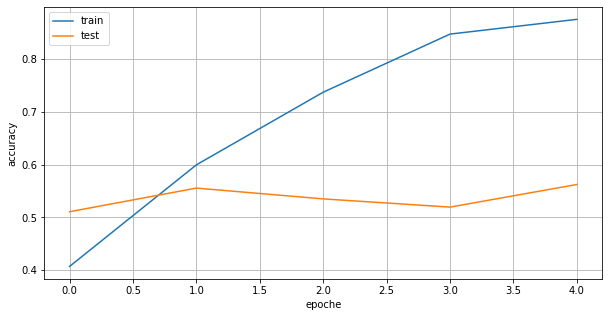

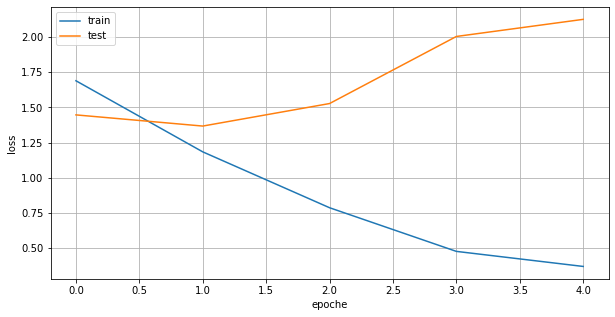

In [11]:
from reporting.training import plot_history
    
plot_history(history)

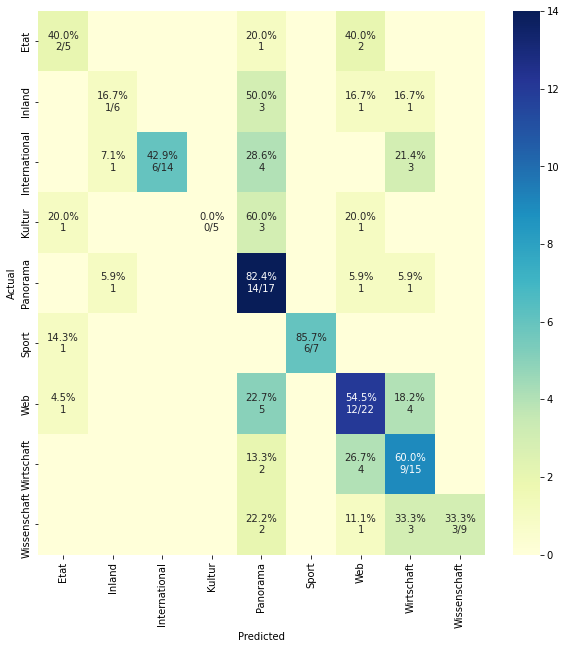

In [12]:
y_predict = label_binarizer.inverse_transform(model.predict(x_test[0:100]))


from reporting.evaluation import plot_confusion_matrix
plot_confusion_matrix(y_test[0:100], y_predict)